# Collaboration and Competition Project

![Screenshot of tennis environment](doc/BannerImage.png)

This is an implementation of the Deep Deterministic Policy Gradients Algorithm for training a agent to play tennis.  The environment contains two agents.  Each agent has a continuous action space corresponding horizontal and vertical paddle motion.  Each agent's observation space consists of the position and velocity of the ball and its racket.  An agent is assigned a reward of +0.1 each time it hits the ball over the net, and a reward of -0.01 if it hits the ball out of bounds, or lets the ball drop on its side of the play area.

To solve the environment, a running average, over 100 consecutive episodes, of the maximum score between the two agents, must be at least +0.5.

## Table of Contents
+ Environment Setup
+ Description of Algorithm
  - N-Step Bootstrapping
  - Prioritized Replay
+ Implementation of Algorithm
  - Hyperparameters
  - Helpers
  - Network Definition
  - Training Code
+ Training
+ Results
+ References

## Environment Setup

+ Follow instructions [here](https://github.com/udacity/Value-based-methods#dependencies) to set up the environment, *with the following changes:*
  - Before running `pip install .`, edit `Value-based-methods/python/requirements.txt` and remove the `torch==0.4.0` line
  - After running `pip install .`, run the appropriate PyTorch installation command for your system indicated [here](https://pytorch.org/get-started/locally/)
  - Continue following the instructions [here](https://github.com/udacity/Value-based-methods#dependencies) to their conclusion.
+ Download the appropriate Unity Environment for your platform:
  - [Linux](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P3/Tennis/Tennis_Linux.zip)
  - [Mac OSX](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P3/Tennis/Tennis.app.zip)
  - [Windows (32-bit)](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P3/Tennis/Tennis_Windows_x86.zip)
  - [Windows (64-bit)](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P3/Tennis/Tennis_Windows_x86_64.zip)
+ Place the Unity Environment zip file into any convenient directory, and unzip the file.

### Imports and references
Run the following code cell at every kernel instance start-up to bring implementation dependencies into the notebook namespace, and identify the path to the simulated environment executable.

In [1]:
from unityagents import UnityEnvironment
from collections import namedtuple, deque
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.optim import Adam

# Set to the path to simulated environment executable on system.
env_location = \
    "C:/Projects/UdacityRLp3/Tennis_Windows_x86_64/Tennis_Windows_x86_64/Tennis.exe"

## Description of Algorithm

The Deep Deterministic Policy Gradient (DDPG) algorithm extends the application of Q-Learning methods to action spaces with continuously valued dimensions [[1]](#References).  There are two networks involved, a Policy Network and Action Value (Q) network.  During learning, the Policy Network generates an action according to the input state, and both this action and the state are supplied to the Q network as input.  The Q network outputs a single action value, and the gradient of this value with respect to the parameters of the Policy Network are used to nudge the policy towards one with a higher action value (by gradient ascent). <br><br> 
In typical Deep Q Learning (DQN), each action has a corresponding output from the Q network, but this representation of the Action Value Function $Q(s,a)$ does not naturally accomodate continuously-valued actions.  The primary difference of DDPG with respect to DQN, is that actions are instead explicit, continuously valued inputs to the Action Value function approximation.  This allows closed-form computation of the gradient of $Q(s,a)$ with respect to changes in magnitudes of the continuously-valued action variables.

The basic DDPG algorithm reads as follows (from [[1]](#References)): <br>
![DDPG Algorithm](doc/DDPG_alg.png) <br>

This implementation does not require that the environment steps and learning steps happen at the same time, or in a 1:1 ratio.  It also incorporates the following improvements:

### N-Step Bootstrapping

The hyperparameter `n_step_order`, determines the value of $n$ in the following alternative Bellman Update target, replacing the definition for $y_i$ in the algorithm above:

$$y_i = r_i + \gamma r_{i+1} + \gamma^2 r_{i+2} + ... + \gamma^n r_{i+n} + \gamma^{n+1} Q'(s_{i+n+1},\mu '(s_{i+n+1}|\theta^{\mu '})|\theta^{Q'})$$

N-Step Bootstrapping increases the relative weight of sampled rewards from the environment, compared to rewards estimated by the Action Value function $Q(s,a)$. Anecdotally, this seems to assist action values propagating backwards in time and through 'bottlenecks' where most nearby states have comparatively low State Values.  So essentially, initial learning can be faster, and some connections may be made that would otherwise take an unacceptably long time to be made without N-Step Bootstrapping.  However, real rewards are stochastic, and an atypically bad or good run of events will  more readily propagate through a Q network with N-Step Bootstrapping.  If an agent quickly changes its behavior between simple, regimented approaches, it is possible the `n_step_order` value in use is too high for the agent's environment.

### Prioritized Replay
The algorithm will periodically switch between exploration and learning phases.  <br><br>During exploration phases, state transition tuples $(S_t,a_t,r_t,S_{t+1})$ will be collected, transformed to *n-step* transition events via an accumulation buffer, and stored in a prioritized experience buffer. 
<br><br>
During learning phases, transition events sampled from the prioritized experience buffer will be used to optimize the parameters of the Policy and Q networks.  Like in [[2]](#References), the probability of utilizing a transition $T$ from the experience buffer is consistent with the proportionality relation: <br><br>
$$p_T \varpropto (Loss)^{\alpha}, \alpha \in [0,\infty)$$
<br>
The hyperparameter $\alpha$ allows tuning of the degree to which the probability of selection is affected by loss magnitude [[2]](#References).
<br><br>Qualitatively, the $Loss$ in this context is proportional to how inconsistent the parameterized model's prediction is with a prediction that uses actual rewards sampled from the environment.  See the implementation section for detail on how the loss is computed.

### Reward Shaping
The signal for failure seemed to require an excessive number of examples to change agent behavior, so a hyperparameter `rwd_mult_neg` was added to allow increasing of the magnitude of the negative reward relative to the positive 'over the net' reward.

### Persistent Experience Storage and Retrieval
Since the training time is dominated by the 'real-time' rate of the Tennis environment's simulation, the functionality to store all experiences from a training run to a file was added.  Further, the implementation allows the experience replay buffer of a new training run to be pre-populated by the experiences from a provided file list.  This enables iteration over different hyperparameter choices much faster, since a new agent can be trained without having to accumulate 500 ball drop experiences every time.

## Implementation of Algorithm

### Hyperparameters

#### Environment
`state_dim`: Dimension of the observable state space<br>
`act_dim`: Dimension of the action space for each agent <br>
`num_agnt`: Number of agents in the environment

#### Network Models
`pol_hid_num`: Number of hidden layers in the Policy Network<br>
`pol_hid_size`: Number of neurons in each hidden layer of the Policy Network<br>
`noise_init`: Initial noise magnitude for Orstein-Uhlenbeck noise applied to policy<br>
`noise_decay`: Noise magnitude is multiplied by this factor after each episode<br>
`noise_sigma`: Magnitude of white noise input to Orstein-Uhlenbeck, see [[1]](#References)<br>
`noise_theta`: Mean-reversion constant for Orstein-Uhlenbeck, see [[1]](#References)<br>
`q_hid_num`: Number of hidden layers in the Q Network<br>
`q_hid_size`: Number of neurons in each hidden layer of the Q Network<br>

#### Reward Parameters
`gamma`: Discount factor per step for rewards<br>
`n_step_order`: Number of reward steps to directly incorporate into Bellman Update estimate<br>

#### Replay Parameters
`buf_life`: Buffer will be reset every this many `sample()` calls to replay buffer<br>
`buf_min_size`: Learning will not be allowed unless replay buffer has this many experiences, to avoid overfitting<br>
`alpha`: Prioritization strength factor, see [[2]](#References)<br>
`beta`: Importance sampling correction coefficient, see [[2]](#References)<br>

#### Optimization Parameters
`pol_lr`: Learning rate for Policy Network optimizer<br>
`q_lr`: Learning rate for Q Network optimizer<br>
`lr_int`: Number of environment episodes between each learning phase<br>
`lr_stps`: How many learning steps are applied during each learning phase<br>
`batch_size`: How many experiences are processed by each agent for each learning step<br>
`p_tau`: Soft update factor for target Policy Network, applied once every learning step<br>
`q_tau`: Soft update factor for the Q Network, applied once every learning step<br>
`rwd_mult_neg`: Multiplier applied to negative rewards issued by the environment before they are incorporated into the experience replay buffer<br>
`pol_upd_int`: Updated policy network only this often relative to q-network update<br>

#### Training Parameters
`max_eps`: Maximum number of episodes for which to train<br>
`avg_wnd_len`: Length (in episodes) of running average buffer for reported performance<br>
`rprt_int`: Number of episodes between prints of performance<br>
`slv_thresh`: Minimum average score constituting solution of environment, the achievement of which will end the training run<br>
`starting_exps_paths`: Python list of paths containing experiences saved from previous training runs.  Each file in the list will have its experiences loaded into the experience replay buffer before starting the training run.<br>
`output_exp_path`: New experiences generated during the training run will be saved to this file path at the run's conclusion.<br>
`random_policy`: If set to `True`, the policy neural network will be ignored when selecting environment actions, and actions will be completely determined by the output of the noise generator.  Potentially useful for getting unbiased initial experiences from which to start other training runs.

In [2]:
class DDPG_Hyperparameters():
    def __init__(self,
                 state_dim=24,
                 act_dim=2,
                 num_agnt=2,
                 pol_hid_num=1,
                 pol_hid_size=100,
                 noise_init=1.0,
                 noise_decay=0.99,
                 noise_theta=0.1,
                 noise_sigma=0.1,
                 q_hid_num=1,
                 q_hid_size=100,
                 gamma=0.9,
                 n_step_order=1,
                 buf_life=1e7,
                 buf_min_size=512,
                 alpha=0.6,
                 beta=1.0,
                 pol_lr=1e-4,
                 q_lr=1e-3,
                 lr_int=10,
                 lr_stps=100,
                 batch_size=64,
                 p_tau=1e-3,
                 q_tau=1e-3,
                 max_eps=1000000,
                 avg_wnd_len=100,
                 rprt_int=100,
                 slv_thresh=0.5,
                 rwd_mult_neg=1.0,
                 pol_upd_int=1,
                 starting_exps_paths = None,
                 output_exp_path = 'exp_output.pkl',
                 random_policy = False
                 ):
        self.state_dim, self.act_dim, self.num_agnt = state_dim, act_dim, num_agnt
        self.pol_hid_num, self.pol_hid_size, self.noise_init = pol_hid_num, pol_hid_size, noise_init
        self.q_hid_num, self.q_hid_size, self.gamma = q_hid_num, q_hid_size, gamma
        self.n_step_order, self.buf_life, self.buf_min_size = n_step_order, buf_life, buf_min_size
        self.alpha, self.beta, self.pol_lr = alpha, beta, pol_lr
        self.q_lr, self.lr_int, self.lr_stps = q_lr, lr_int, lr_stps
        self.batch_size, self.p_tau, self.q_tau = batch_size, p_tau, q_tau
        self.max_eps, self.avg_wnd_len, self.rprt_int = max_eps, avg_wnd_len, rprt_int
        self.slv_thresh, self.noise_decay, self.noise_theta = slv_thresh, noise_decay, noise_theta
        self.rwd_mult_neg, self.pol_upd_int, self.noise_sigma = rwd_mult_neg, pol_upd_int, noise_sigma
        self.starting_exps_paths, self.output_exp_path = starting_exps_paths, output_exp_path
        self.random_policy = random_policy

def_hyp = DDPG_Hyperparameters()

### Helpers

In [3]:
# Debugging function
def tensor_check(input,desc,exp_size):
    if torch.any(torch.isnan(input)):
        print(f'NaNs in {desc}:')
        print(input)
    if torch.any(torch.isinf(input)):
        print(f'Inf in {desc}:')
        print(input)
    if not (input.size() == torch.Size(exp_size)):
        print(f'{desc} has size {tuple(input.size())}, not {exp_size} expected')

# Copied from the Lunar Lander dqn_agent.py file of the Udacity repo for course
def soft_update(local_model, target_model, tau):
    """Soft update model parameters.
    θ_target = τ*θ_local + (1 - τ)*θ_target

    Params
    ======
        local_model (PyTorch model): weights will be copied from
        target_model (PyTorch model): weights will be copied to
        tau (float): interpolation parameter 
    """
    for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
        target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

# Object that represents an experience in the experience buffer or a non-leaf node of the sum tree
# Experience tuples are stored in the self.data attribute
# Based on code in Reference [3]
class SumTreeNode():
    
    def __init__(self,data=None,p_i=0):
        self.data = data
        self.p_i = p_i
        self.parent = None
        self.left_child = None
        self.right_child = None
    
    def update_p(self, delta_p):
        self.p_i += delta_p
        if self.parent is not None:
            self.parent.update_p(delta_p)
    
    def attach_child(self,child):
        if self.data is None:    # Not a leaf node
            if self.left_child is None:    # No children, become leaf with cloned data
                self.data = child.data
                self.update_p(child.p_i - self.p_i)
            else:    # Non-leaf node, attach to lower p_i side
                if self.left_child.p_i < self.right_child.p_i:
                    delegate_node = self.left_child
                else:
                    delegate_node = self.right_child
                delegate_node.attach_child(child)
        else:    # self is a leaf-node.  Clone self.data into new child, become non-leaf
            self.left_child = SumTreeNode(self.data,self.p_i)
            self.data = None
            self.right_child = child
            self.left_child.parent, self.right_child.parent = self, self     
            self.update_p((self.left_child.p_i + self.right_child.p_i)- self.p_i)
    
    def weighted_retrieve(self,p_samp):
        if self.data is not None: # must be a leaf-node
            return self
        else:
            if self.left_child.p_i >= p_samp:
                return self.left_child.weighted_retrieve(p_samp)
            else:
                return self.right_child.weighted_retrieve(p_samp - self.left_child.p_i)
        
# Experience aggregate
Experience = namedtuple('Experience',['state','action','reward','last_state'])
        
class PrioritizedReplayBuffer():
    
    def __init__(self,hyp):
        self.buf_life = hyp.buf_life
        self.alpha = hyp.alpha
        self.store = SumTreeNode()
        self.sample_count = 0
        self.exp_count = 0
        self.beta = hyp.beta
    
    def __len__(self):
        return self.exp_count
    
    def add_experience(self, experience, loss):
        new_p_i = pow(loss, self.alpha)
        self.store.attach_child(SumTreeNode(experience, new_p_i))
        self.exp_count += 1
            
    def sample(self,batch_size):
        sample_keys = (np.random.rand(batch_size)*self.store.p_i).tolist()
        samples = ([self.store.weighted_retrieve(p_samp) for p_samp in sample_keys],
                   (self.exp_count,self.store.p_i))
        self.sample_count += 1
        if (self.sample_count >= self.buf_life):
            self.sample_count = 0
            self.store = SumTreeNode()
            self.exp_count = 0
            print ('\nFlushed replay buffer!\n')
        return samples
    
# Circular buffer for generation of n_step rewards
class MultistepBuffer():
    def __init__(self,hyp):
        self.n_step_order = hyp.n_step_order
        self.store = deque(maxlen = hyp.n_step_order + 1)
        self.gamma = hyp.gamma
    
    def add_experience(self,exp):
        self.store.append(exp)
    
    def ready(self):
        return len(self.store) == (self.n_step_order + 1)
    
    def get_n_step_experience(self):
        out_state = self.store[0].state
        out_action = self.store[0].action
        out_reward = \
            sum([((self.store[i].reward) * pow(self.gamma,i)) for i in range(self.n_step_order)])
        out_final_state = self.store[-1].state
        return SumTreeNode(Experience(out_state, out_action, out_reward, out_final_state),p_i=1)
    
# Logger for running average
class PerformanceLogger():
    def __init__(self,avg_wnd_len=100,starting_scores=None):
        self.avg_wnd_len = avg_wnd_len
        self.scores = starting_scores if starting_scores is not None else []
        self.internal_run_avg = 0
        
    def add_score(self,score):
        self.scores.append(score)
        self.internal_run_avg += score / self.avg_wnd_len
        # Remove tail of running average
        if len(self.scores) > self.avg_wnd_len:
            self.internal_run_avg -= self.scores[-(self.avg_wnd_len + 1)] / self.avg_wnd_len
    
    def has_full_window(self):
        return len(self.scores) >= self.avg_wnd_len
    
    def run_avg(self):
        if len(self.scores) == 0:
            return 0
        return self.internal_run_avg \
                * (1 if self.has_full_window() else (self.avg_wnd_len/len(self.scores)))
    
# Ohrstein-Uhlenbeck Process Noise Generator
class OhrsteinUhlenbeckGen():
    def __init__(self,out_dim=1,theta=1.0,sigma=1.0):
        self.state = torch.zeros(out_dim,dtype=torch.float32)
        self.out_dim = out_dim
        self.theta = theta
        self.sigma = sigma
        
    def reset(self):
        self.state = torch.zeros(self.out_dim,dtype=torch.float32)
        
    def sample(self):
        step_noise = self.sigma * \
                         torch.clamp(torch.randn(self.out_dim,dtype=torch.float32),-5.0,5.0)
        self.state = ((1.0 - self.theta) * self.state) + step_noise
        return step_noise
    
# Aggregate saved experiences and metadata
ExperienceSet = namedtuple('ExperienceSet',['hyperparams','exps'])

# Save list of experiences
def save_experiences(hyp,exp_list):
    torch.save(ExperienceSet(hyp,exp_list),hyp.output_exp_path)
    print(f'Saved {len(exp_list)} experiences to {hyp.output_exp_path}')

# Initialize replay buffer
def load_experiences(hyp):
    out_buf = PrioritizedReplayBuffer(hyp)
    if hyp.starting_exps_paths is None:
        return out_buf
    for exp_set_path in hyp.starting_exps_paths:
        exp_set = torch.load(exp_set_path)
        for exp in exp_set.exps:
            out_buf.add_experience(exp,1.0)
    print(f'\nReplay buffer created with initial size {len(out_buf)}')
    return out_buf

### Network Definition

In [4]:
# Generic MLP
class DDPG_Subnet(nn.Module):
    def __init__(self, 
                 in_dim, 
                 out_dim, 
                 hid_size, 
                 num_hid,
                 squish_output=False
                 ):
        super(DDPG_Subnet,self).__init__()
        
        layers = []
        layers.append(nn.Linear(in_dim, hid_size))
        layers.append(nn.ReLU())
        for i in range(num_hid-1):
            layers.append(nn.Linear(hid_size, hid_size))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hid_size, out_dim))
        self.reg_layers = nn.Sequential(*layers)
        
        self.squish_output = squish_output
        
    def forward(self,x):
        x = x.float()
        x = self.reg_layers(x)
        if self.squish_output:
            x = torch.tanh(x)
        return x

# Generators
def new_pol_net(hyp):
    return DDPG_Subnet(hyp.state_dim*hyp.num_agnt,
                       hyp.act_dim*hyp.num_agnt,
                       hyp.pol_hid_size,
                       hyp.pol_hid_num,
                       True)
                       
def new_q_net(hyp):
    return DDPG_Subnet((hyp.state_dim + hyp.act_dim)*hyp.num_agnt,
                       1,
                       hyp.q_hid_size,
                       hyp.q_hid_num,
                       False)

### Training Code

#### `train_net` Parameters
`q_net`: Q network to use for training run<br>
`pol_net`: Policy network to use for training run<br>
`env`: Environment to use for training run<br>
`hyp`: `DDPG_Hyperparameters` object to use for training run<br>

#### `train_net` Returns
Reference to a `PerformanceLogger` with the score data

In [5]:
# Helper to compute importance sampling weight corrections
def comp_w_i(experiences, hyp, device):
    
    p_i_total = experiences[1][1]
    buf_N = experiences[1][0]
    # Normalized p_i see eqn (1) of reference [3]
    p_i = torch.tensor([(e.p_i/p_i_total) for e in experiences[0]]).to(device)
    p_i = torch.clamp(p_i,min=1e-9)
    w_i = torch.pow(torch.reciprocal(torch.mul(buf_N,p_i)),hyp.beta).unsqueeze(dim=1)
    w_i = torch.clamp(w_i,1e-8,1.0)
    
    return w_i

def Q_Loss(q_net, q_trg, pol_trg, experiences, hyp, device):
    
    init_states = torch.vstack([e.data.state for e in experiences[0]]).to(device)
    actions = torch.vstack([e.data.action for e in experiences[0]]).to(device)
    rewards = torch.tensor([e.data.reward for e in experiences[0]]).unsqueeze(dim=1).to(device)
    final_states = torch.vstack([e.data.last_state for e in experiences[0]]).to(device)

    q_net_input = torch.cat((init_states,actions),dim=1).float()
    #tensor_check(q_net_input,'Q Loss q_net_input',(len(experiences[0]),hyp.state_dim + hyp.act_dim))
    q_net_output = q_net(q_net_input)
    
    q_trg_input = torch.cat((final_states,pol_trg(final_states)),dim=1).float()
    #tensor_check(q_trg_input,'q_trg_input',(len(experiences[0]),hyp.state_dim + hyp.act_dim))
    q_trg_output = q_trg(q_trg_input)
    
    disc = pow(hyp.gamma,hyp.n_step_order)
    #tensor_check(rewards,'rewards',(len(experiences[0]),1))
    q_loss = (rewards + (disc * q_trg_output)) - q_net_output
    q_loss = torch.pow(q_loss,2)
    #tensor_check(q_loss,'q_loss',(len(experiences[0]),1))
    
    # Importance sampling weights
    w_i = comp_w_i(experiences, hyp, device)
    #tensor_check(w_i,'w_i',(len(experiences[0]),1))
    
    return (torch.mul(q_loss,w_i), w_i)
    
def Pol_Loss(q_net, pol_net, experiences, hyp, device):
    
    init_states = torch.vstack([e.data.state for e in experiences[0]]).to(device)
    w_i = comp_w_i(experiences, hyp, device)
    q_net_input = torch.cat((init_states,pol_net(init_states)),dim=1).float()
    #tensor_check(q_net_input,'Pol Loss q_net_input',(len(experiences[0]),hyp.state_dim+hyp.act_dim))
    q_net_output = q_net(q_net_input)
    weighted_output = torch.mul(q_net_output,w_i)
    tensor_check(weighted_output,'weighted_output',(len(experiences[0]),1))
    out_loss = torch.mul(-1.0,torch.mean(weighted_output))
    #tensor_check(out_loss,'out_loss',())
    return out_loss

# Processing of completed n-step experiences
def process_new_exp(hyp, device, out_exp_list, n_step_buf, replay_buffer, q_net, q_trg, pol_trg):

    if n_step_buf.ready():        
                
        n_step_exp = n_step_buf.get_n_step_experience()

        # Compute losses to determine sampling priorities, add new states to replay buffer
        q_net.eval(); q_trg.eval(); pol_trg.eval()
        loss, w_i = Q_Loss(q_net, q_trg, pol_trg, 
                           ([n_step_exp],(1,1)), 
                           hyp, device)
        pol_trg.train(); q_trg.train(); q_net.train()
        p_i = torch.div(loss,w_i).squeeze(dim=1)
        replay_buffer.add_experience(n_step_exp.data,p_i.item())
        out_exp_list.append(n_step_exp.data)

def train_net(pol_net, q_net, env, hyp):
    
    # Use gpu if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Move primary models to device
    pol_net = pol_net.to(device)
    q_net = q_net.to(device)
    
    # Generate target policy and q networks
    pol_trg = new_pol_net(hyp).to(device)
    q_trg = new_q_net(hyp).to(device)
    
    # Initialize target networks, copy policy, zeroed q network
    soft_update(pol_net, pol_trg, 1.0)
    soft_update(q_net, q_trg, 1.0)
        
    # Setup optimizers
    pol_optim = Adam(pol_net.parameters(), lr=hyp.pol_lr)
    q_optim = Adam(q_net.parameters(), lr=hyp.q_lr)
    
    # Init counters
    lrn_cntr = 0
    pol_upd_cntr = 0
    rpt_cntr = 0
    
    # Unity ML-Agents Setup
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    
    # Initialize replay buffer, performance log, experience list for saving
    replay_buffer = load_experiences(hyp)
    perf_log = PerformanceLogger(avg_wnd_len = hyp.avg_wnd_len)
    out_exps = []
    
    # Noise generator
    noise_gen = OhrsteinUhlenbeckGen(hyp.act_dim*hyp.num_agnt,hyp.noise_theta,hyp.noise_sigma)
    noise_factor = hyp.noise_init
    noise_decay = hyp.noise_decay
    
    for episode in range(hyp.max_eps):
        
        noise_gen.reset()
        n_step_buf = MultistepBuffer(hyp)
        env_info = env.reset(train_mode=False)[brain_name]
        states = env_info.vector_observations
        scores = [0]*hyp.num_agnt
        dones = [False]*hyp.num_agnt
        
        while dones.count(True) < hyp.num_agnt:
            
            in_states = torch.tensor(states,device=device).reshape((1,hyp.state_dim*hyp.num_agnt))
            if not hyp.random_policy:
                pol_net.eval()
                actions = pol_net(in_states).reshape((hyp.num_agnt,hyp.act_dim)).cpu().detach()
                pol_net.train()
            else:
                actions = torch.zeros((hyp.num_agnt,hyp.act_dim))
            
            act_noise = noise_factor*noise_gen.sample().reshape((hyp.num_agnt, hyp.act_dim))
            actions = torch.clamp(torch.add(actions,act_noise),-1.0,1.0)
            
            env_info = env.step(actions.numpy())[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            env_dones = env_info.local_done
            
            tot_step_rwd = 0
            for i in range(hyp.num_agnt):
                
                if dones[i] == False:
                    
                    scores[i] += rewards[i]
                    tot_step_rwd += rewards[i]*(1.0 if rewards[i] >= 0 else hyp.rwd_mult_neg)
                    dones[i] = env_dones[i]
            
            new_exp = Experience(in_states.cpu().detach(),
                                 actions.reshape((1,hyp.num_agnt*hyp.act_dim)),
                                 tot_step_rwd,
                                 None)
            n_step_buf.add_experience(new_exp)
            
            process_new_exp(hyp, device, out_exps, n_step_buf, replay_buffer, q_net, q_trg, pol_trg)
                
            # Handle rewards assigned at end of episodes.  Repeat state push into
            # multistep buffer and add resulting n_step experience
            if dones.count(True) >= hyp.num_agnt:
                n_step_buf.add_experience(new_exp)
                process_new_exp(hyp, device, out_exps, n_step_buf, 
                                replay_buffer, q_net, q_trg, pol_trg)
                
            states = next_states
            
        lrn_cntr += 1
        if (lrn_cntr % hyp.lr_int) == 0:

            lrn_cntr = 0
            if len(replay_buffer) > max(hyp.buf_min_size, hyp.batch_size):

                q_perf_log = PerformanceLogger()
                pol_perf_log = PerformanceLogger()
                for l_step in range(hyp.lr_stps):

                    # Check that a sample op did not trigger reset
                    if len(replay_buffer) < max(hyp.buf_min_size, hyp.batch_size):
                        break

                    samp_exp = replay_buffer.sample(hyp.batch_size)

                    # Q Network Update
                    q_optim.zero_grad()
                    loss, w_i = Q_Loss(q_net, q_trg, pol_trg, samp_exp, hyp, device)
                    tensor_check(loss,'q_loss',(hyp.batch_size,1))
                    mean_loss = torch.mean(loss)
                    mean_loss.backward()
                    q_optim.step()
                    q_perf_log.add_score(mean_loss.item())
                    new_p_i = torch.div(loss,w_i).pow(hyp.alpha).squeeze(dim=1)

                    pol_upd_cntr += 1
                    if (pol_upd_cntr == hyp.pol_upd_int):
                        pol_upd_cntr = 0
                        # Policy Network Update
                        q_optim.zero_grad()
                        pol_optim.zero_grad()
                        loss = Pol_Loss(q_net, pol_net, samp_exp, hyp, device)
                        loss.backward()
                        pol_optim.step()
                        pol_perf_log.add_score(loss.item())

                    # Update priorities in replay buffer according to losses
                    for exp_num in range(hyp.batch_size):
                        samp_exp[0][exp_num].update_p( \
                            (new_p_i[exp_num].item() - samp_exp[0][exp_num].p_i))

                    # Update target networks
                    soft_update(q_net, q_trg, hyp.q_tau)
                    soft_update(pol_net, pol_trg, hyp.p_tau)

                    # Output status of optimization
                    q_avg = q_perf_log.run_avg()
                    p_avg = pol_perf_log.run_avg()
                    print(f'Completed {l_step + 1} of {hyp.lr_stps} learning steps. ' +
                          f'Q Loss = {q_avg:.5f}, Policy Value = {-p_avg:.5f}', end='\r')

        perf_log.add_score(max(scores))
        noise_factor = noise_factor * noise_decay
        
        if perf_log.has_full_window() and (perf_log.run_avg() >= hyp.slv_thresh):
            print(f'Solved with average score of {perf_log.run_avg()} in {episode+1} episodes')
            break
        
        rpt_cntr += 1
        if (rpt_cntr % hyp.rprt_int) == 0:
            rpt_cntr = 0
            print(f'\nCompleted {episode + 1} episodes. Average score = {perf_log.run_avg():.3f}')
        
        if episode == (hyp.max_eps - 1):
            print(f'Failed to solve within the maximum of {hyp.max_eps} episodes')
            break

    # Save experience list to file
    save_experiences(hyp, out_exps)
    
    return perf_log

## Training

In [6]:
# First get some random experiences where a few balls are hit over, 
# for initializing other runs
starter_hyp = DDPG_Hyperparameters(noise_init=5.0,
                                   noise_decay=0.9999,
                                   noise_theta=0.1,
                                   noise_sigma=0.1,
                                   n_step_order=1,
                                   lr_int=1e6,
                                   max_eps=200,
                                   rwd_mult_neg=3.0,
                                   output_exp_path='starter_exps.pkl',
                                   random_policy=True)

pol_net = new_pol_net(starter_hyp)
q_net = new_q_net(starter_hyp)
env = UnityEnvironment(file_name=env_location)
rslt = train_net(pol_net, q_net, env, starter_hyp)
env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 



Completed 100 episodes. Average score = 0.017

Completed 200 episodes. Average score = 0.019
Failed to solve within the maximum of 200 episodes
Saved 3600 experiences to starter_exps.pkl


In [6]:
# Run with relatively hot parameters.  
# Get enough experiences to be able to learn to get consistent serves, 
# and avoid common pitfalls
serving_hyp = DDPG_Hyperparameters(pol_hid_num=3,
                                   pol_hid_size=512,
                                   noise_init=5.0,
                                   noise_decay=0.999,
                                   noise_theta=0.1,
                                   noise_sigma=0.5,
                                   q_hid_num=3,
                                   q_hid_size=512,
                                   gamma=0.85,
                                   alpha=0.0,
                                   beta=1.0,
                                   pol_lr=5e-5,
                                   q_lr=5e-5,
                                   buf_min_size=512,
                                   lr_int=10,
                                   lr_stps=200,
                                   batch_size=512,
                                   p_tau=1e-3,
                                   q_tau=1e-3,
                                   max_eps=1500,
                                   rwd_mult_neg=3.0,
                                   starting_exps_paths=['starter_exps.pkl'],
                                   output_exp_path='serving_exps.pkl'
                                  ) 

pol_net = new_pol_net(serving_hyp)
q_net = new_q_net(serving_hyp)
env = UnityEnvironment(file_name=env_location)
rslt = train_net(pol_net, q_net, env, serving_hyp)
env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 



Replay buffer created with initial size 3600
Completed 200 of 200 learning steps. Q Loss = 0.00023, Policy Value = -0.04425
Completed 100 episodes. Average score = 0.008
Completed 200 of 200 learning steps. Q Loss = 0.00013, Policy Value = 0.014940
Completed 200 episodes. Average score = 0.020
Completed 200 of 200 learning steps. Q Loss = 0.00009, Policy Value = 0.02392
Completed 300 episodes. Average score = 0.014
Completed 200 of 200 learning steps. Q Loss = 0.00009, Policy Value = 0.02158
Completed 400 episodes. Average score = 0.012
Completed 200 of 200 learning steps. Q Loss = 0.00008, Policy Value = 0.01459
Completed 500 episodes. Average score = 0.009
Completed 200 of 200 learning steps. Q Loss = 0.00006, Policy Value = 0.00870
Completed 600 episodes. Average score = 0.016
Completed 200 of 200 learning steps. Q Loss = 0.00006, Policy Value = 0.00348
Completed 700 episodes. Average score = 0.011
Completed 200 of 200 learning steps. Q Loss = 0.00007, Policy Value = 0.00060
Comple

In [6]:
# Run with relatively cool parameters using the previous experiences
cool_hyp = DDPG_Hyperparameters(pol_hid_num=3,
                                pol_hid_size=512,
                                noise_init=2.5,
                                noise_decay=0.999,
                                noise_theta=0.33,
                                noise_sigma=0.5,
                                q_hid_num=3,
                                q_hid_size=512,
                                gamma=0.85,
                                alpha=0.0,
                                beta=1.0,
                                pol_lr=5e-6,
                                q_lr=5e-6,
                                buf_min_size=512,
                                lr_int=10,
                                lr_stps=400,
                                batch_size=512,
                                p_tau=5e-4,
                                q_tau=5e-4,
                                max_eps=3000,
                                rwd_mult_neg=3.0,
                                starting_exps_paths=['starter_exps.pkl','serving_exps.pkl'],
                                output_exp_path='cool_exps.pkl'
                               ) 


pol_net = new_pol_net(cool_hyp)
q_net = new_q_net(cool_hyp)
env = UnityEnvironment(file_name=env_location)
rslt = train_net(pol_net, q_net, env, cool_hyp)
env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 



Replay buffer created with initial size 32195
Completed 400 of 400 learning steps. Q Loss = 0.00235, Policy Value = 0.36411
Completed 100 episodes. Average score = 0.003
Completed 400 of 400 learning steps. Q Loss = 0.00083, Policy Value = 0.29299
Completed 200 episodes. Average score = 0.003
Completed 400 of 400 learning steps. Q Loss = 0.00047, Policy Value = 0.22619
Completed 300 episodes. Average score = 0.001
Completed 400 of 400 learning steps. Q Loss = 0.00031, Policy Value = 0.16928
Completed 400 episodes. Average score = 0.019
Completed 400 of 400 learning steps. Q Loss = 0.00024, Policy Value = 0.12284
Completed 500 episodes. Average score = 0.017
Completed 400 of 400 learning steps. Q Loss = 0.00021, Policy Value = 0.08604
Completed 600 episodes. Average score = 0.014
Completed 400 of 400 learning steps. Q Loss = 0.00019, Policy Value = 0.05781
Completed 700 episodes. Average score = 0.024
Completed 400 of 400 learning steps. Q Loss = 0.00018, Policy Value = 0.03603
Complet

In [6]:
# Try higher gamma, to make how easy it is to return a hit ball have more
# influence over how ball is hit.  Also added a layer to each network and
# increased learning rates in case improvement stall due to local minima
# residence
four_hyp = DDPG_Hyperparameters(pol_hid_num=4,
                                pol_hid_size=512,
                                noise_init=1.25,
                                noise_decay=0.99,
                                noise_theta=0.33,
                                noise_sigma=0.5,
                                q_hid_num=4,
                                q_hid_size=512,
                                gamma=0.95,
                                alpha=0.0,
                                beta=1.0,
                                pol_lr=1e-4,
                                q_lr=1e-4,
                                buf_min_size=512,
                                lr_int=100,
                                lr_stps=8000,
                                batch_size=512,
                                p_tau=1e-3,
                                q_tau=1e-3,
                                max_eps=2000,
                                rwd_mult_neg=3.0,
                                starting_exps_paths=['starter_exps.pkl',
                                                     'serving_exps.pkl',
                                                     'cool_exps.pkl'],
                                output_exp_path='run_four_exps.pkl'
                               ) 


pol_net = new_pol_net(four_hyp)
q_net = new_q_net(four_hyp)
env = UnityEnvironment(file_name=env_location)
rslt = train_net(pol_net, q_net, env, four_hyp)
env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 



Replay buffer created with initial size 90081
Completed 8000 of 8000 learning steps. Q Loss = 0.00016, Policy Value = 0.09202
Completed 100 episodes. Average score = 0.018
Completed 8000 of 8000 learning steps. Q Loss = 0.00026, Policy Value = 0.04915
Completed 200 episodes. Average score = 0.051
Completed 8000 of 8000 learning steps. Q Loss = 0.00031, Policy Value = 0.04961
Completed 300 episodes. Average score = 0.100
Completed 8000 of 8000 learning steps. Q Loss = 0.00029, Policy Value = 0.06851
Completed 400 episodes. Average score = 0.119
Completed 8000 of 8000 learning steps. Q Loss = 0.00029, Policy Value = 0.09172
Completed 500 episodes. Average score = 0.131
Completed 8000 of 8000 learning steps. Q Loss = 0.00031, Policy Value = 0.11950
Completed 600 episodes. Average score = 0.148
Completed 8000 of 8000 learning steps. Q Loss = 0.00027, Policy Value = 0.14164
Completed 700 episodes. Average score = 0.133
Completed 8000 of 8000 learning steps. Q Loss = 0.00026, Policy Value =

In [6]:
# Still some difficulty past the first / second hit.
# Lower discount rate (higher gamma).  Lower learning rates
# by factor of two as attempt to avoid divergence
five_hyp = DDPG_Hyperparameters(pol_hid_num=4,
                                pol_hid_size=512,
                                noise_init=1.25,
                                noise_decay=0.995,
                                noise_theta=0.33,
                                noise_sigma=0.5,
                                q_hid_num=4,
                                q_hid_size=512,
                                gamma=0.96,
                                alpha=0.0,
                                beta=1.0,
                                pol_lr=5e-5,
                                q_lr=5e-5,
                                buf_min_size=512,
                                lr_int=100,
                                lr_stps=16000,
                                batch_size=512,
                                p_tau=1e-3,
                                q_tau=1e-3,
                                max_eps=2000,
                                rwd_mult_neg=3.0,
                                starting_exps_paths=['starter_exps.pkl',
                                                     'serving_exps.pkl',
                                                     'cool_exps.pkl',
                                                     'run_four_exps.pkl'],
                                output_exp_path='run_five_exps.pkl'
                               ) 


pol_net = new_pol_net(five_hyp)
q_net = new_q_net(five_hyp)
env = UnityEnvironment(file_name=env_location)
rslt = train_net(pol_net, q_net, env, five_hyp)
env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 



Replay buffer created with initial size 189064
Completed 16000 of 16000 learning steps. Q Loss = 0.00052, Policy Value = -0.02681
Completed 100 episodes. Average score = 0.021
Completed 16000 of 16000 learning steps. Q Loss = 0.00052, Policy Value = 0.03642
Completed 200 episodes. Average score = 0.216
Completed 16000 of 16000 learning steps. Q Loss = 0.00055, Policy Value = 0.08074
Completed 300 episodes. Average score = 0.196
Completed 16000 of 16000 learning steps. Q Loss = 0.00060, Policy Value = 0.12156
Completed 400 episodes. Average score = 0.252
Completed 16000 of 16000 learning steps. Q Loss = 0.00059, Policy Value = 0.16710
Completed 500 episodes. Average score = 0.302
Completed 16000 of 16000 learning steps. Q Loss = 0.00063, Policy Value = 0.21070
Completed 600 episodes. Average score = 0.219
Completed 16000 of 16000 learning steps. Q Loss = 0.00063, Policy Value = 0.24868
Completed 700 episodes. Average score = 0.156
Completed 16000 of 16000 learning steps. Q Loss = 0.000

In [6]:
# Looks like got numerically unstable after peaking, around episode 500.
# Lower gamma some.  Also set steps per learning phase real high since
# should have a lot to work from without an immediate need for more
# experiences.
six_hyp = DDPG_Hyperparameters(pol_hid_num=4,
                                pol_hid_size=512,
                                noise_init=1.25,
                                noise_decay=0.995,
                                noise_theta=0.33,
                                noise_sigma=0.5,
                                q_hid_num=4,
                                q_hid_size=512,
                                gamma=0.93,
                                alpha=0.0,
                                beta=1.0,
                                pol_lr=5e-5,
                                q_lr=5e-5,
                                buf_min_size=512,
                                lr_int=100,
                                lr_stps=16000,
                                batch_size=512,
                                p_tau=1e-3,
                                q_tau=1e-3,
                                max_eps=2000,
                                rwd_mult_neg=3.0,
                                starting_exps_paths=['starter_exps.pkl',
                                                     'serving_exps.pkl',
                                                     'cool_exps.pkl',
                                                     'run_four_exps.pkl',
                                                     'run_five_exps.pkl'],
                                output_exp_path='run_six_exps.pkl'
                               ) 


pol_net = new_pol_net(six_hyp)
q_net = new_q_net(six_hyp)
env = UnityEnvironment(file_name=env_location)
rslt = train_net(pol_net, q_net, env, six_hyp)
env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 



Replay buffer created with initial size 283729
Completed 16000 of 16000 learning steps. Q Loss = 0.00029, Policy Value = 0.06110
Completed 100 episodes. Average score = 0.018
Completed 16000 of 16000 learning steps. Q Loss = 0.00033, Policy Value = 0.03452
Completed 200 episodes. Average score = 0.049
Solved with average score of 0.5210000078938898 in 263 episodes
Saved 23387 experiences to run_six_exps.pkl


In [7]:
# Save final models
torch.save(pol_net,f'pol_net_final.pt')
torch.save(q_net,'q_net_final.pt')

## Results

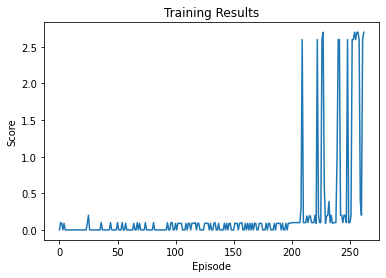

In [8]:
plt.plot(rslt.scores)
plt.title('Training Results')
plt.ylabel('Score')
plt.xlabel('Episode')
plt.show()

### Discussion
Quite a lot of runs were required to determine hyperparameters that resulted in stable learning.<br>
The persistent storage of experiences, and their recovery before starting training runs, were implemented in anticipation of far more iterations being required.  However, this feature seemed to result in success relatively quickly.  Learning with this method may have not only made training take less time, but improved performance.  This is because, by the time an agent starts making a certain class of mistakes, it has also become habituated to making those mistakes (local minima).  Starting fresh with a new neural network, that's able to access the failed experiences of previous runs, is one way of escaping the local minima while retaining the knowledge obtained there.

Note from the training plot that the persistent experiences from previous runs were almost entirely responsible for success, as 250 episodes is very small relative to the benchmark plot Udacity provided, which demonstrated a requirement of 1500 episodes to solve the environment.

### Demo
The cell below can be run to demonstrate the behavior of the trained agent. It is necessary to first run all cells except those in the training section. One can also review this [video](https://youtu.be/XOyMPkYiyz4) of the trained agent's behavior.

In [6]:
demo_eps = 5

env = UnityEnvironment(file_name=env_location)
demo_pol_net = torch.load('submission_pol_net.pt')
demo_q_net = torch.load('submission_q_net.pt')
demo_hyp = DDPG_Hyperparameters(noise_init=0.0,
                                pol_hid_num=4,
                                pol_hid_size=512,
                                q_hid_num=4,
                                q_hid_size=512,
                                max_eps=demo_eps,
                                lr_int=(demo_eps*1e9),
                                rprt_int=1,
                                slv_thresh=1e9
                               )

train_net(demo_pol_net,demo_q_net,env,demo_hyp)
env.close()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 



Completed 1 episodes. Average score = 0.100

Completed 2 episodes. Average score = 0.150

Completed 3 episodes. Average score = 0.130

Completed 4 episodes. Average score = 0.173

Completed 5 episodes. Average score = 0.658
Failed to solve within the maximum of 5 episodes
Saved 1237 experiences to exp_output.pkl


### Ideas for Future Work

+ The agent is fairly brittle as evidenced by the results plot.  Either the agent drops the ball quickly, or settles into a stable routine from which the ball never drops.  Training a single-sided agent against a random policy opponent might eventually result in a more robust agent.
+ The persistent experience storage mechanism was very helpful, and seems like it should be implemented with any reinforcement learning problem before training starts.  A more flexible library implementation would be valuable.
+ Apply the algorithm to more current Unity environments could aid in development of intuition.

## References
[1] Lillicrap et. al., Continuous control with deep reinforcement learning, [arXiv:1509.02971](https://arxiv.org/abs/1509.02971) <br>
[2] Schaul et. al., Prioritized Experience Replay, [arXiv:1511.05952](https://arxiv.org/abs/1511.05952)<br>
[3] http://www.sefidian.com/2022/09/09/sumtree-data-structure-for-prioritized-experience-replay-per-explained-with-python-code/<br>
